In [4]:
from analysis_scripts.onfly_decon_codestacks import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from fish_helpers import *
from analysis_scripts.classify import *
import cv2
import time
md_path = '/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/'
md = Metadata(md_path)

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
import subprocess as sp
import os

def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values
get_gpu_memory()

[8119]

In [6]:
from tqdm import tqdm
import cv2
import random
from skimage.filters import threshold_otsu
def find_hot_pixels(md,n_pos=5,std_thresh=3,n_acqs=5,kernel_size=3):
    if kernel_size%2==0:
        kernel_size = kernel_size+1
    kernel = np.ones((kernel_size,kernel_size))
    kernel[int(kernel_size/2),int(kernel_size/2)] = 0
    kernel = kernel/np.sum(kernel)
    X = []
    Y = []
    acqs = [i for i in md.image_table.acq.unique() if 'hybe' in i]
    poses = md.image_table[md.image_table.acq.isin(acqs)].Position.unique()
    hot_pixel_dict = {}
    if len(poses)>n_pos:
        poses = random.sample(list(poses),n_pos)
    for pos in tqdm(poses):
        pos_md =  md.image_table[md.image_table.Position==pos]
        acqs = pos_md.acq.unique()
        if len(acqs)>n_acqs:
            acqs = random.sample(list(acqs),n_acqs)
        for acq in acqs:
            hot_pixel_dict[acq] = {}
            channels = pos_md[pos_md.acq==acq].Channel.unique()
            channels = set(list(channels)).intersection(['FarRed','Orange'])
            for channel in channels:
                img = np.average(md.stkread(Position=pos,Channel=channel,acq=acq),axis=2)
                bkg_sub = img-cv2.filter2D(img,-1,kernel)
                avg = np.average(bkg_sub)
                std = np.std(bkg_sub)
                thresh = (avg+(std_thresh*std))
                loc = np.where(bkg_sub>thresh)
                X.extend(loc[0])
                Y.extend(loc[1])
    img = np.histogram2d(X,Y,bins=2048,range=[[0,2048],[0,2048]])[0]
    loc = np.where(img>threshold_otsu(img))
    return img,loc,X,Y

In [7]:
img,loc,X,Y = find_hot_pixels(md,n_pos=1)

100%|██████████| 1/1 [00:23<00:00, 23.02s/it]


In [8]:
config = pd.DataFrame(['value'],columns=['parameter'])
config['dtype_rel_min']=0
config['dtype_rel_max']=100
config['dtype']='float64'
config['background_kernel']=9
config['blur_kernel']=1
config['background_method']='median'
config['hotpixel_kernel_size']=3
config['normalization_rel_min']=50
config['normalization_rel_max']=95
config['deconvolution_niterations']=10
config['deconvolution_batches']=10
config['deconvolution_gpu']=True
config['projection_zstart']=-1
config['projection_k']=1
config['projection_zskip']=2 
config['projection_zend']=-1
config['projection_function']='mean'
config['verbose']=False
config['ncpu']=10
config['normalization_max']=1000
config.T

,0
parameter,value
dtype_rel_min,0
dtype_rel_max,100
dtype,float64
background_kernel,9
blur_kernel,1
background_method,median
hotpixel_kernel_size,3
normalization_rel_min,50
normalization_rel_max,95


In [9]:
config_dict = {}
for column in config.columns:
    config_dict[column] = config[column].iloc[0]
config_dict

{'parameter': 'value',
 'dtype_rel_min': 0,
 'dtype_rel_max': 100,
 'dtype': 'float64',
 'background_kernel': 9,
 'blur_kernel': 1,
 'background_method': 'median',
 'hotpixel_kernel_size': 3,
 'normalization_rel_min': 50,
 'normalization_rel_max': 95,
 'deconvolution_niterations': 10,
 'deconvolution_batches': 10,
 'deconvolution_gpu': True,
 'projection_zstart': -1,
 'projection_k': 1,
 'projection_zskip': 2,
 'projection_zend': -1,
 'projection_function': 'mean',
 'verbose': False,
 'ncpu': 10,
 'normalization_max': 1000}

In [10]:
class MERFISH_image_processing(object):
    def __init__(self,
                 sub_stk,
                 channel,
                 translation_x,
                 translation_y,
                 hotpixel_X,
                 hotpixel_Y,
                 config_dict):
        self.config = config_dict
        self.sub_stk = sub_stk
        self.projection_function=config_dict['projection_function']
        if len(self.sub_stk.shape)==2:
            self.img = self.sub_stk
        elif len(self.sub_stk.shape)==3:
            self.img = self.project_image(sub_stk)
        else:
            raise(ValueError('Sub_stk can only by 2 or 3d',sub_stk.shape))
        self.len_x,self.len_y = self.img.shape
        self.channel = channel
        self.translation_x=translation_x
        self.translation_y=translation_y
        self.hotpixel_X=hotpixel_X
        self.hotpixel_Y=hotpixel_Y
        self.dtype=config_dict['dtype']
        self.background_kernel=config_dict['background_kernel']
        self.blur_kernel=config_dict['blur_kernel']
        self.background_method=config_dict['background_method']
        self.hotpixel_kernel_size=config_dict['hotpixel_kernel_size']
        self.load_chromatic()
        self.create_hotpixel_kernel()
        self.verbose = config_dict['verbose']
        self.process_image()
    
    def project_image(self,sub_stk):
        if self.projection_function == 'max':
            img = sub_stk.max(axis=2)
        elif self.projection_function == 'mean':
            img = sub_stk.mean(axis=2)
        elif self.projection_function == 'median':
            img = sub_stk.median(axis=2)
        return img
        
    def convert_image_bit(self):
        self.img = self.img.astype(self.dtype)
    
    def subtract_background(self):
        if self.background_method =='median':
            self.bkg = median_filter(self.img,self.background_kernel)
        if self.background_method == 'gaussian':
            self.bkg = gaussian_filter(self.img,self.background_kernel)
        self.img = self.img-self.bkg
        if self.blur_kernel>0:
            self.img = gaussian_filter(self.img,self.blur_kernel)
    
    def create_hotpixel_kernel(self):
        kernel = np.ones((self.hotpixel_kernel_size,self.hotpixel_kernel_size))
        kernel[int(self.hotpixel_kernel_size/2),int(self.hotpixel_kernel_size/2)] = 0
        self.hotpixel_kernel = kernel/np.sum(kernel)
        
    def remove_hotpixels(self):
        self.img[self.hotpixel_X,self.hotpixel_Y] = convolve(self.img,self.hotpixel_kernel)[self.hotpixel_X,self.hotpixel_Y]
    
    def load_chromatic(self):
        self.chromatic_x = chromatic_dict[self.channel]['x']
        self.chromatic_y = chromatic_dict[self.channel]['y']
        
    def register_image_xy(self):
        i2 = interpolate.interp2d(self.chromatic_x+self.translation_x, self.chromatic_y+self.translation_y, self.img)
        self.img = i2(range(self.len_x), range(self.len_y))
    
    def process_image(self):
        self.convert_image_bit()
        self.remove_hotpixels()
        self.subtract_background()
        self.register_image_xy()

# def img_process(img,
#                 channel=None,
#                  translation_x=0,
#                  translation_y=0,
#                  hotpixel_X=[],
#                  hotpixel_Y=[],
#                  dtype='float64',
#                  background_kernel=9,
#                  blur_kernel=1,
#                  background_method='median',
#                  hotpixel_kernel_size=3,
#                  verbose=True):
#     img_class = MERFISH_image_processing(img,
#                                      channel,
#                                      translation_x,
#                                      translation_y,
#                                      hotpixel_X,
#                                      hotpixel_Y,
#                                      dtype=dtype,
#                                      background_kernel=background_kernel,
#                                      blur_kernel=blur_kernel,
#                                      background_method=background_method,
#                                      hotpixel_kernel_size=hotpixel_kernel_size,
#                                      verbose=verbose)
#     return img_class.img


# channel = 'FarRed'
# acq = [i for i in md.acqnames if 'hybe1' in i][0]
# stk = md.stkread(Position='Pos1',Channel=channel,acq=acq)
# pfunc = partial(img_process,
#                 channel=channel,
#                 translation_x=1,
#                 translation_y=1,
#                 hotpixel_X=X,
#                 hotpixel_Y=Y,
#                 dtype='float64',
#                 background_kernel=9,
#                 blur_kernel=1,
#                 background_method='median',
#                 hotpixel_kernel_size=3,
#                 verbose=True)

# start= time.time()
# pool = multiprocessing.Pool(stk.shape[2])
# Input = [stk[:,:,i] for i in range(stk.shape[2])]
# sys.stdout.flush()
# results = pool.imap(pfunc,Input)
# out = np.zeros_like(stk).astype('float64')
# for z,img in tqdm(enumerate(results),total=stk.shape[2]):
#     out[:,:,z] = img 
# pool.close()
# sys.stdout.flush()
# print(time.time()-start)
# Display(out[:,:,19],rel_min=50,rel_max=100)

In [15]:
import threading
import time


class ThreadingExample(object):
    """ Threading example class
    The run() method will be started and it will run in the background
    until the application exits.
    """

    def __init__(self, interval=1):
        """ Constructor
        :type interval: int
        :param interval: Check interval, in seconds
        """
        self.interval = interval

        thread = threading.Thread(target=self.run, args=())
        thread.daemon = True                            # Daemonize thread
        thread.start()                                  # Start the execution

    def run(self):
        """ Method that runs forever """
        while True:
            # Do something
            print('Doing something imporant in the background')

            time.sleep(self.interval)

example = ThreadingExample()
time.sleep(3)
print('Checkpoint')
time.sleep(2)
print('Bye')

Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Checkpoint
Doing something imporant in the background
ByeDoing something imporant in the background

Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the background
Doing something imporant in the backgro

Deconvolving Stack:   0%|          | 0/5 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0717 10:24:38.962885 140098361907008 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/flowdec/restoration.py:144: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 10:24:38.968250 140098361907008 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/flowdec/restoration.py:223: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 10:24:38.986416 140098361907008 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/flowdec/restoration.py:233: The name tf.assert_greater is deprecated. Please use tf.compat.v1.assert_greater instead.

W0717 10:24:39.010070 140098361907008 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots

137.06464314460754


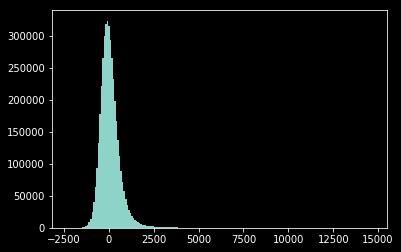

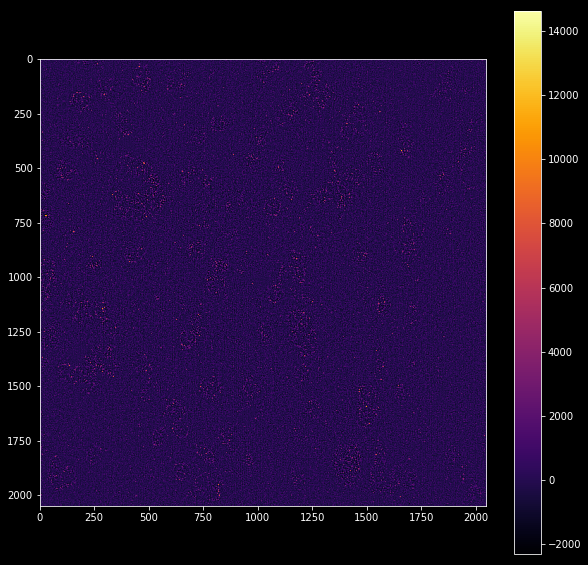

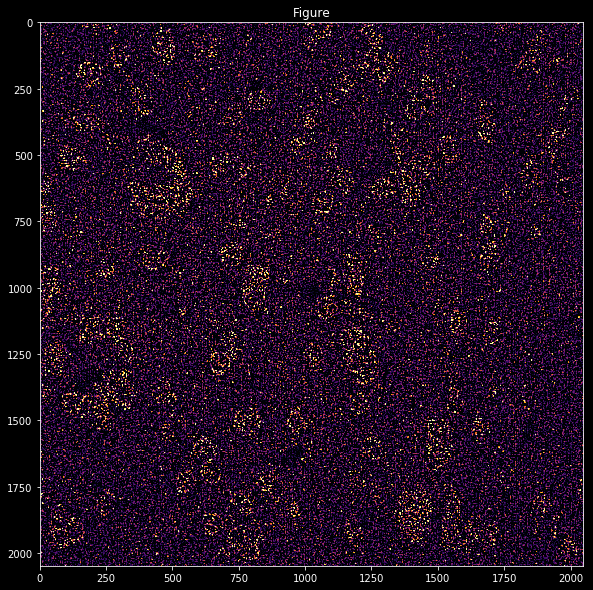

In [11]:
from hybescope_config.microscope_config import *
from scipy.ndimage import median_filter,gaussian_filter
from scipy.ndimage.filters import convolve

class MERFISH_stack_processing(object):
    def __init__(self,
                 stk,
                 channel,
                 translation_x,
                 translation_y,
                 translation_z,
                 hotpixel_X,
                 hotpixel_Y,
                 config_dict,verbose=False):
        self.config = config_dict
        self.stk = stk
        self.len_x,self.len_y,self.len_z = stk.shape
        self.channel = channel
        self.translation_x=translation_x
        self.translation_y=translation_y
        self.translation_z=translation_z
        self.hotpixel_X=hotpixel_X
        self.hotpixel_Y=hotpixel_Y
        self.dtype_rel_min=config_dict['dtype_rel_min']
        self.dtype_rel_max=config_dict['dtype_rel_max']
        self.dtype=config_dict['dtype']
        self.background_kernel=config_dict['background_kernel']
        self.blur_kernel=config_dict['blur_kernel']
        self.background_method=config_dict['background_method']
        self.hotpixel_kernel_size=config_dict['hotpixel_kernel_size']
        self.normalization_rel_min=config_dict['normalization_rel_min']
        self.normalization_rel_max=config_dict['normalization_rel_max']
        self.deconvolution_niterations=config_dict['deconvolution_niterations']
        self.deconvolution_batches=config_dict['deconvolution_batches']
        self.gpu=config_dict['deconvolution_gpu']
        self.projection_zstart=config_dict['projection_zstart'] 
        self.projection_k=config_dict['projection_k']
        self.projection_zskip=config_dict['projection_zskip'] 
        self.projection_zend=config_dict['projection_zend']
        self.projection_function=config_dict['projection_function']
        self.verbose = verbose
        self.ncpu = config_dict['ncpu']
        self.normalization_max = config_dict['normalization_max']
  
    def process_stack(self):
        self.transform_stack_z()
        Input = self.generate_substks()
        if self.verbose:
            iterable = tqdm(enumerate(Input),total=self.len_z,desc = 'Processing stack')
        else:
            iterable = enumerate(Input)
        for z,sub_stk in iterable:
            self.processed_stk[:,:,z] = self.process_image(sub_stk)
        self.deconvolve_stack()
        self.normalize_stack()
        
    def transform_stack_z(self):
        zindexes = np.array(range(0,self.len_z))
        t_zindexes = zindexes+self.translation_z
        mask = (t_zindexes<0)|(t_zindexes>=self.len_z)
        tform_stk = np.zeros_like(self.stk)
        if self.verbose:
            iterable = tqdm(enumerate(t_zindexes),total=len(t_zindexes),desc='Transforming Z')
        else:
            iterable = enumerate(t_zindexes)
        for i,z in iterable:
            if (z>=0)&(z<self.len_z):
                tform_stk[:,:,z] = self.stk[:,:,i]
        self.stk = tform_stk
        
    def generate_substks(self):
        self.check_projection()
        self.zindexes = np.array(range(self.projection_zstart,self.projection_zend,self.projection_zskip))
        self.len_z = len(self.zindexes)
        self.processed_stk = np.zeros((self.len_x,self.len_y,len(self.zindexes)))
        if self.verbose:
            iterable = tqdm(self.zindexes,total=len(self.zindexes),desc='Generating Sub Stacks')
        else:
            iterable = self.zindexes
        Input = [self.stk[:,:,z-self.projection_k:z+self.projection_k] for z in iterable]
        return Input
    
    def check_projection(self):
        if self.projection_function=='None':
            self.projection_k = 0
        if self.projection_zstart==-1:
            self.projection_zstart = 0+self.projection_k
        elif self.projection_zstart>self.len_z:
            print('zstart of ',self.projection_zstart,' is larger than stk range of', self.len_z)
            raise(ValueError('Projection Error'))
        if self.projection_zend==-1:
            self.projection_zend = self.len_z-self.projection_k
        elif self.projection_zend>self.len_z:
            print('zend of ',self.projection_zend,' is larger than stk range of', self.len_z)
            raise(ValueError('Projection Error'))
        elif zend<zstart:
            print('zstart of ',self.projection_zstart,' is larger than zend of', self.projection_zend)
            raise(ValueError('Projection Error'))
            
    def process_image(self,sub_stk):
        self.img_class = MERFISH_image_processing(sub_stk,
                                             self.channel,
                                             self.translation_x,
                                             self.translation_y,
                                             self.hotpixel_X,
                                             self.hotpixel_Y,
                                             self.config)
        return self.img_class.img
        
    def deconvolve_stack(self):
        # Dump stk and psf to a to to do file
        # Demon will load file, decnvolve and dump
        # here we will scan a processed file for the output 
        # then load and delete processed file
        #http://sebastiandahlgren.se/2014/06/27/running-a-method-as-a-background-thread-in-python/
        self.load_psf()
        stk = self.processed_stk.astype('float64')
        stk = stk-stk.min()
        stk = stk/stk.max()
        if self.verbose:
            iterable = tqdm(range(int(round(self.deconvolution_batches/2))),desc='Deconvolving Stack')
        else:
            iterable = range(int(round(self.deconvolution_batches/2)))
        step = int(self.len_x/(self.deconvolution_batches/2))
        if self.gpu:
            free_gpu_memory = get_gpu_memory()[0]
            start = time.time()
            while free_gpu_memory<5000:
                if (time.time()-start)>300:
                    raise(ValueError('GPU isnt Free'))
                free_gpu_memory = get_gpu_memory()[0]
            gpu_algorithm = fd_restoration.RichardsonLucyDeconvolver(3).initialize()
            if self.deconvolution_batches>1:
                for i in iterable:
                    i0 = int(step*i)
                    for j in iterable:
                        j0 = int(step*j)
                        temp = stk[i0:i0+step,j0:j0+step,:]
                        if self.gpu:
                            stk[i0:i0+step,j0:j0+step,:] = gpu_algorithm.run(fd_data.Acquisition(data=temp, kernel=self.psf), niter=self.deconvolution_niterations).data
                        else:
                            stk[i0:i0+step,j0:j0+step,:] = restoration.richardson_lucy(temp, self.psf,self.deconvolution_niterations, clip=False)
            else:
                stk = gpu_algorithm.run(fd_data.Acquisition(data=stk, kernel=self.psf), niter=self.deconvolution_niterations).data
        else:
            stk = restoration.richardson_lucy(stk, self.psf,self.deconvolution_niterations, clip=False)
        self.processed_stk = stk
        
    def load_psf(self):
        self.psf = psf_dict_3d[self.channel]
        
    def normalize_stack(self):
        if self.verbose:
            iterable = tqdm(range(self.len_z),desc='Normalizing Stack')
        else:
            iterable = range(self.len_z)
        for z in iterable:
            self.processed_stk[:,:,z] = self.normalize_image(self.processed_stk[:,:,z])
            
    def normalize_image(self,img):
        if np.sum(img.ravel())==0:
            return img
        else:
            img = img-np.percentile(img.ravel(),self.normalization_rel_min)
            img = img/np.percentile(img.ravel(),self.normalization_rel_max)
            img = img*self.normalization_max
            return img
        
import time
start = time.time()
channel = 'FarRed'
acq = [i for i in md.acqnames if 'hybe1' in i][0]
stk = md.stkread(Position='Pos1',Channel=channel,acq=acq)
stk_class = MERFISH_stack_processing(stk,
                                     channel,
                                     1,
                                     1,
                                     1,
                                     X,
                                     Y,
                                     config_dict,
                                     verbose=True)
stk_class.process_stack()
print(time.time()-start)
img = stk_class.processed_stk[:,:,5].copy()
plt.hist(img.ravel(),200)
plt.show()
plt.figure(figsize=[10,10])
plt.imshow(img,cmap='inferno')
plt.colorbar()
plt.show()
Display(img,rel_min=50,rel_max=99.9999)

In [13]:
import pickle
import time
start = time.time()
pickle.dump(stk_class,open('/home/zach/Downloads/test.pkl','wb'))
print(time.time()-start)

7.932354688644409


In [14]:
import pickle
import time
start = time.time()
temp = pickle.load(open('/home/zach/Downloads/test.pkl','rb'))
print(time.time()-start)

1.4165620803833008


In [ ]:
# Decon Que System

In [13]:
def process_stk_helper(stk_class):
    stk_class.process_stack()
    return stk_class

In [15]:
class MERFISH_fov_class(object):
    def __init__(self,posname,
                 md_path,
                 codestack_path,
                 seqfish_config,
                 tform,
                 hotpixel_X,
                 hotpixel_Y,
                 config_dict,
                 fresh=False,
                 verbose=True):
#                  verbose=True,fresh=False,normalization_max=1000,ncpu=20):
        self.config = config_dict
        self.posname = posname
        self.md_path = md_path
        self.codestack_path = codestack_path
        self.hdata_path = os.path.join(codestack_path,posname)
        self.hdata = HybeData(self.hdata_path)
        self.md = Metadata(md_path)
        self.zindexes = self.md.image_table[self.md.image_table.Position==posname].Zindex.unique()
        # which z indexes for cstk 
        self.seqfish_config = seqfish_config
        self.nbits = seqfish_config.nbits
        self.bitmap = seqfish_config.bitmap
        self.tform = tform
        self.len_x = 2048
        self.len_y = 2048
        self.len_z = len(self.zindexes)
        self.hotpixel_X = hotpixel_X
        self.hotpixel_Y = hotpixel_Y
        self.verbose = verbose
        self.fresh = fresh
        self.normalization_max = config_dict['normalization_max']
        self.ncpu=config_dict['ncpu']
        
    def load_tesseract(self):
        tesseract = np.zeros((self.len_x,self.len_y,self.len_z,self.nbits))
        if not self.fresh:
            if self.verbose:
                iterable = tqdm(self.hdata.metadata.zindex.unique(),desc='Loading Tesseract')
            else:
                iterable = self.hdata.metadata.zindex.unique()
            for z in iterable:
                if z!='all':
                    try:
                        tesseract[:,:,int(z),:] = self.hdata.load_data(self.posname, z, 'cstk')
                    except:
                        print(z)
                        print(self.hdata.load_data(self.posname, z, 'cstk'))
                        raise(ValueError())
        self.tesseract = tesseract
    
    def save_tesseract(self):
        self.tesseract[self.tesseract<0]=0
        for z in self.stk_class.zindexes:
            self.hdata.add_and_save_data(self.tesseract[:,:,z,:], self.posname, z, 'cstk')
            self.hdata.add_and_save_data(self.normalization_max*np.ones(self.nbits), self.posname, z, 'nf')
            self.hdata.add_and_save_data(np.zeros((self.len_x,self.len_y)), self.posname, z, 'cimg')
            
    def covert_tforms(self):
        if self.verbose:
            iterable = tqdm(self.tform.items(),total=len(self.tform.keys()),desc='Converting Tforms')
        else:
            iterable = self.tform.items()
        tforms_xyz = {k: (v[0][0], v[0][1], int(np.round(np.mean(v[0][2])))) for k, v in iterable if k!='nucstain'}
        self.translation_y = {k: v[0] for k, v in tforms_xyz.items()}
        self.translation_x = {k: v[1] for k, v in tforms_xyz.items()}
        self.translation_z = {k: v[2] for k, v in tforms_xyz.items()}

    def check_completed(self):
        seqs, hybes, channels = zip(*self.bitmap)
        hybes, channels = np.array(hybes), np.array(channels)
        completed_idx = np.array([i for i in range(len(hybes)) if hybes[i] in self.translation_x])
        if self.fresh:
            completed_not_processed_idx = completed_idx
        else:
            completed_not_processed_idx = np.array([i for i in completed_idx if np.max(self.tesseract[:,:,:,i].ravel())==0])

        self.completed_not_processed_idx = completed_not_processed_idx
        
    def generate_stk_class(self,bitmap_idx):
        seq, hybe, channel = self.bitmap[bitmap_idx]
        stk = self.md.stkread(Position=self.posname,Channel=channel,hybe=hybe)
        stk_class = MERFISH_stack_processing(stk,
                                             channel,
                                             self.translation_x[hybe],
                                             self.translation_y[hybe],
                                             self.translation_z[hybe],
                                             self.hotpixel_X,
                                             self.hotpixel_Y,
                                             self.config)
        return stk_class

    def generate_stk_input(self):
        if self.verbose:
            iterable = tqdm(self.completed_not_processed_idx,desc='Generate Stack Input')
        else:
            iterable = self.completed_not_processed_idx
        Input = [self.generate_stk_class(bitmap_idx) for bitmap_idx in iterable]
        return Input
    
    def process_stk_wrapper(self):
        self.check_completed()
        Input = self.generate_stk_input()
        pool = multiprocessing.Pool(self.ncpu)
        sys.stdout.flush()
        results = pool.imap(process_stk_helper, Input)
        pool.close()
        sys.stdout.flush()
        if self.verbose:
            iterable = tqdm(enumerate(results),total=len(self.completed_not_processed_idx),desc='Processing Stacks')
        else:
            iterable = enumerate(results)
        for i,stk_class in iterable:
            bitmap_idx = self.completed_not_processed_idx[i]
            temp_stk = self.tesseract[:,:,:,bitmap_idx].copy()
            for i,z in enumerate(stk_class.zindexes):
                temp_stk[:,:,z] = stk_class.processed_stk[:,:,i]
            self.tesseract[:,:,:,bitmap_idx] = temp_stk
        
    def preprocess_tesseract(self):
        self.load_tesseract()
        self.covert_tforms()
        self.process_stk_wrapper()
#         self.save_tesseract()
          
    
posname = 'Pos1'
good_positions = pickle.load(open(os.path.join(md_path,'results','tforms.pkl'),'rb'))['good']
tform = good_positions[posname]
codestack_path = os.path.join(md_path,'codestacks')
cword_config = 'seqfish_config_zebrafinch'
seqfish_config = importlib.import_module(cword_config)
# img,loc,X,Y = find_hot_pixels(md,n_pos=1)
fov_class = MERFISH_fov_class(posname,md_path,codestack_path,seqfish_config,tform,X,Y,config_dict,fresh=True)
# fov_class.preprocess_tesseract()

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [17]:
fov_class = MERFISH_fov_class(posname,md_path,codestack_path,seqfish_config,tform,X,Y,config_dict,fresh=False)
fov_class.load_tesseract()

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
Loading Tesseract: 100%|██████████| 17/17 [01:13<00:00,  4.35s/it]


In [ ]:
"""
Wrapper
"""
good_positions = pickle.load(open(os.path.join(md_path,'results','tforms.pkl'),'rb'))['good']
codestack_path = os.path.join(md_path,'codestacks_v2')
cword_config = 'seqfish_config_zebrafinch'
seqfish_config = importlib.import_module(cword_config)
img,loc,X,Y = find_hot_pixels(md,n_pos=5)
for posname in tqdm(good_positions.keys()):
    tform = good_positions[posname]
    fov_class = MERFISH_fov_class(posname,md_path,codestack_path,seqfish_config,tform,X,Y,fresh=True,verbose=False)
    fov_class.preprocess_tesseract()
